# <font color='blue'>Regression Team Project</font>
**Fast Campus Data Science School 7th**

## Overview
- Team: Team B-5 committer (김선웅, 이영인, 장승우)
- Subject: New York City Taxi Trip Duration
- Dataset: 2016 NYC Cab trip record data (by TLC)
- Objective: Building a model that predicts the duration of each trip in New York City.

## Data fields
- id - 각 운행별 고유 id
- vendor_id - 운행별 각 택시 회사의 id
- pickup_datetime - 승차 날짜/시각 (미터기 기록 시작)
- dropoff_datetime - 하차 날짜/시각 (미터기 기록 종료)
- passenger_count - 승객 수
- pickup_longitude - 승차 위도
- pickup_latitude - 승차 경도
- dropoff_longitude - 하차 위도
- dropoff_latitude - 하차 경도
- store_and_fwd_flag - 운행 기록 서비 전송 전 차량 메모리 저장 여부 (Y: 저장/전송, N: 미저장/전송)
- trip_duration - 운행 소요 시간 (초)

## Index

### 1. 데이터 탐색 및 전처리
- Train/Test Data 탐색
- 변수 기초 전처리

### 2. 변수 탐색 및 선택
- 변수 시각화
- 상관관계
- 변수 중요도/영향 파악

### 3. Modeling
- 변수 미조정
- 변수 조정
- 다항회귀
- 결과 진단


- Leverage & Outlier
- Hyperparameter tuning


### 7. Cross Validation

## 1. 데이터 탐색 및 전처리

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk

from patsy import dmatrices

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

/Users/sunwoongkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1-1. train & test data 기본 탐색

In [2]:
train = pd.read_csv("../../dataset/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
print("Shape of Train Data: ", train.shape)

Shape of Train Data:  (1458644, 11)


In [3]:
test = pd.read_csv("../../dataset/test.csv", parse_dates=["pickup_datetime"])
print("Shape of Test Data: ", test.shape)

Shape of Test Data:  (625134, 9)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [6]:
for col in train.columns:
    if col != "id":
        print("The number of unique values of {col}: {num}".format(col=col, num=len(train[col].unique())))

The number of unique values of vendor_id: 2
The number of unique values of pickup_datetime: 1380222
The number of unique values of dropoff_datetime: 1380377
The number of unique values of passenger_count: 10
The number of unique values of pickup_longitude: 23047
The number of unique values of pickup_latitude: 45245
The number of unique values of dropoff_longitude: 33821
The number of unique values of dropoff_latitude: 62519
The number of unique values of store_and_fwd_flag: 2
The number of unique values of trip_duration: 7417


In [7]:
print("Features only in training data:", set(train.columns) - set(test.columns))

Features only in training data: {'dropoff_datetime', 'trip_duration'}


In [8]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [9]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


### [데이터 기초 탐색 결과]

1. vendor는 두 곳
2. 승객 수는 0명부터 9명
3. 승차 위치와 하차 위치는 크게 다르지 않아 보임
4. store and fwd flag의 데이터는 N/Y로 표현되어 binarize 필요해 보임
5. trip duration의 경우 최댓값이 평균에 비해 아주 크며, 최솟값과 최댓값간의 차이 또한 매우 큼

### 1-2. 데이터 전처리

### datetime

- datetime parsing
    - month
    - weekday
    - hour


- working day 카테고리 생성

In [10]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["pickup_hour"] = train["pickup_datetime"].dt.hour

train.shape

(1458644, 14)

In [11]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri
train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)

### store_and_fwd_flag
- binarize를 통해 문자열 labeling

In [12]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

### 좌표 데이터 (pickup_latitude/pickup_longitude, dropoff_latitude/dropoff_longitude)
- distance (haversine distance) 계산
- bearing (direction) 계산

In [13]:
lat1, lng1, lat2, lng2 = (train['pickup_latitude'].values, train['pickup_longitude'].values, 
                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)

In [14]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [15]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360 # from -180/180 to 0/360

In [16]:
train = train.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
train = train.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

### 전처리 후 추가된 변수

- 시간
    - pickup_month
    - pickup_weekday
    - pickup_hour
    - working_day (categorical variable)


- 위치
    - distance
    - bearing

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null int64
trip_duration         1458644 non-null int64
pickup_month          1458644 non-null int64
pickup_weekday        1458644 non-null int64
pickup_hour           1458644 non-null int64
working_day           1458644 non-null int64
distance              1458644 non-null float64
bearing               1458644 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(8), object(1)
memory usage: 189.2+ MB


In [18]:
print(train.shape)
print()
for col in train.columns:
    if col != "id":
        print("The number of unique values of {col}: {num}".format(col=col, num=len(train[col].unique())))

(1458644, 17)

The number of unique values of vendor_id: 2
The number of unique values of pickup_datetime: 1380222
The number of unique values of dropoff_datetime: 1380377
The number of unique values of passenger_count: 10
The number of unique values of pickup_longitude: 23047
The number of unique values of pickup_latitude: 45245
The number of unique values of dropoff_longitude: 33821
The number of unique values of dropoff_latitude: 62519
The number of unique values of store_and_fwd_flag: 2
The number of unique values of trip_duration: 7417
The number of unique values of pickup_month: 6
The number of unique values of pickup_weekday: 7
The number of unique values of pickup_hour: 24
The number of unique values of working_day: 2
The number of unique values of distance: 1452285
The number of unique values of bearing: 1452020


In [19]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,0.006,959.492,3.517,3.050,13.606,0.715,3.441,153.406
std,0.499,1.314,0.071,0.033,0.071,0.036,0.074,5237.432,1.681,1.954,6.400,0.452,4.297,104.220
min,1.000,0.000,-121.933,34.360,-121.933,32.181,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,0.000,397.000,2.000,1.000,9.000,0.000,1.232,44.305
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,0.000,662.000,4.000,3.000,14.000,1.000,2.094,168.517
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,0.000,1075.000,5.000,5.000,19.000,1.000,3.875,224.361
max,2.000,9.000,-61.336,51.881,-61.336,43.921,1.000,3526282.000,6.000,6.000,23.000,1.000,1240.909,359.993


In [20]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,4,13,1,1.225080,240.940662
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,655,1,6,7,0,6.049836,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,4,6,1,7.824606,209.211508
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,1,15,1,1.092564,35.033294
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,0,198,4,1,14,1,1.134042,29.969486


### 2. 변수 탐색 및 선택

### 2-1  변수 시각화

### trip_duration의 분포

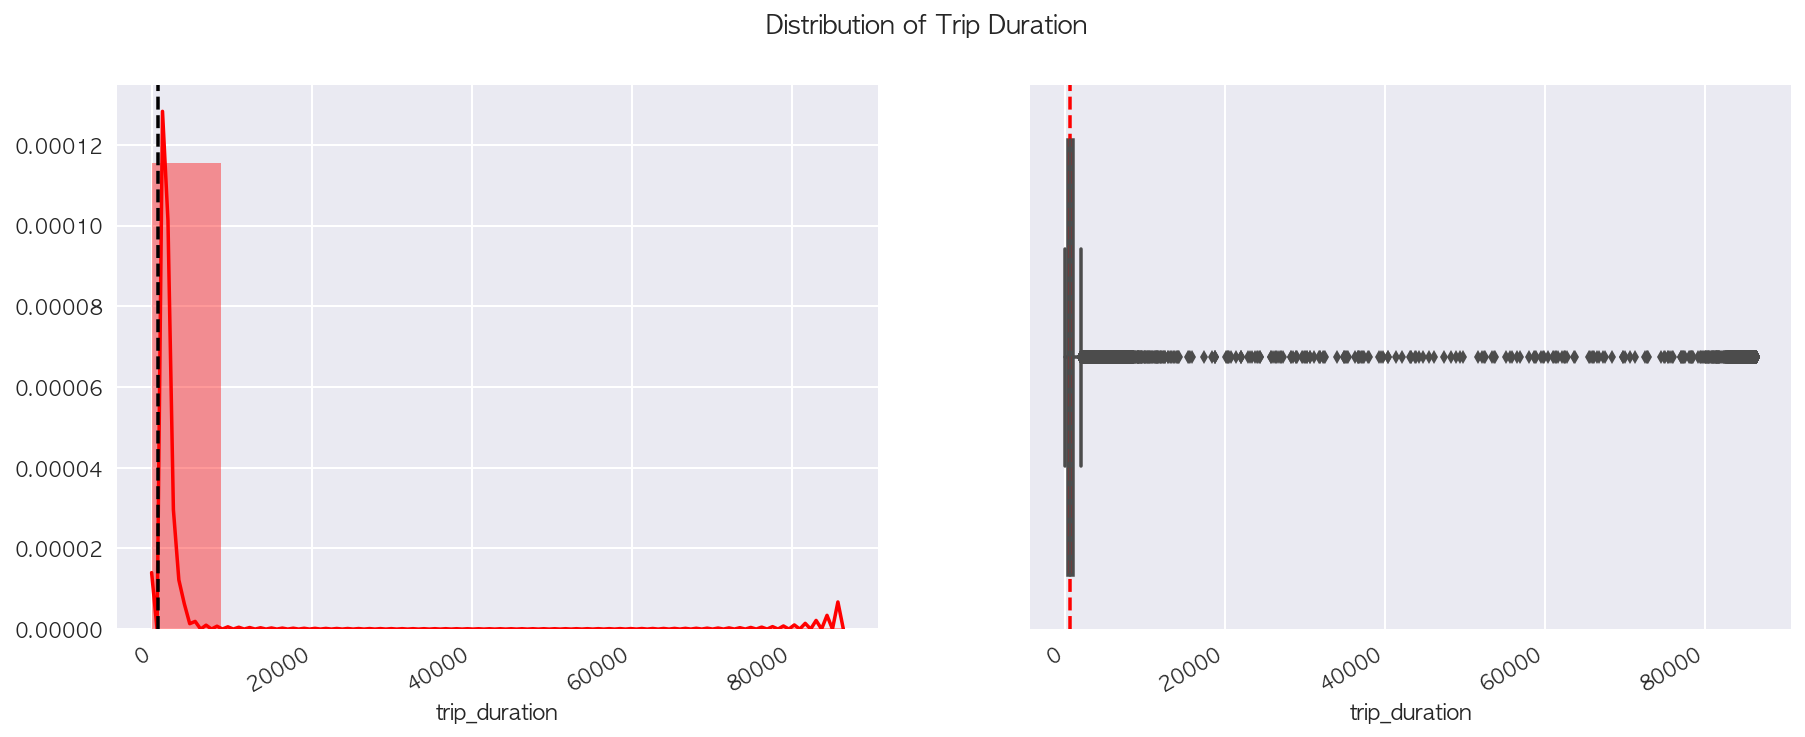

In [141]:
plt.figure(figsize=(15, 5))
plt.suptitle("Distribution of Trip Duration", fontsize=13)

plt.subplot(121)
sns.distplot(train["trip_duration"], color="r",bins=10)
plt.axvline(train["trip_duration"].median(), linestyle='dashed', color="k")
plt.xticks(rotation=30, ha='right')

plt.subplot(122)
sns.boxplot(train["trip_duration"])
plt.axvline(train["trip_duration"].median(), linestyle='dashed', color="r")
plt.xticks(rotation=30, ha='right')

plt.show()

In [170]:
train[train["trip_duration"] > 1500000]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing


- **500시간이 넘는 데이터 존재: 잘못 입력된 데이터로 보임**

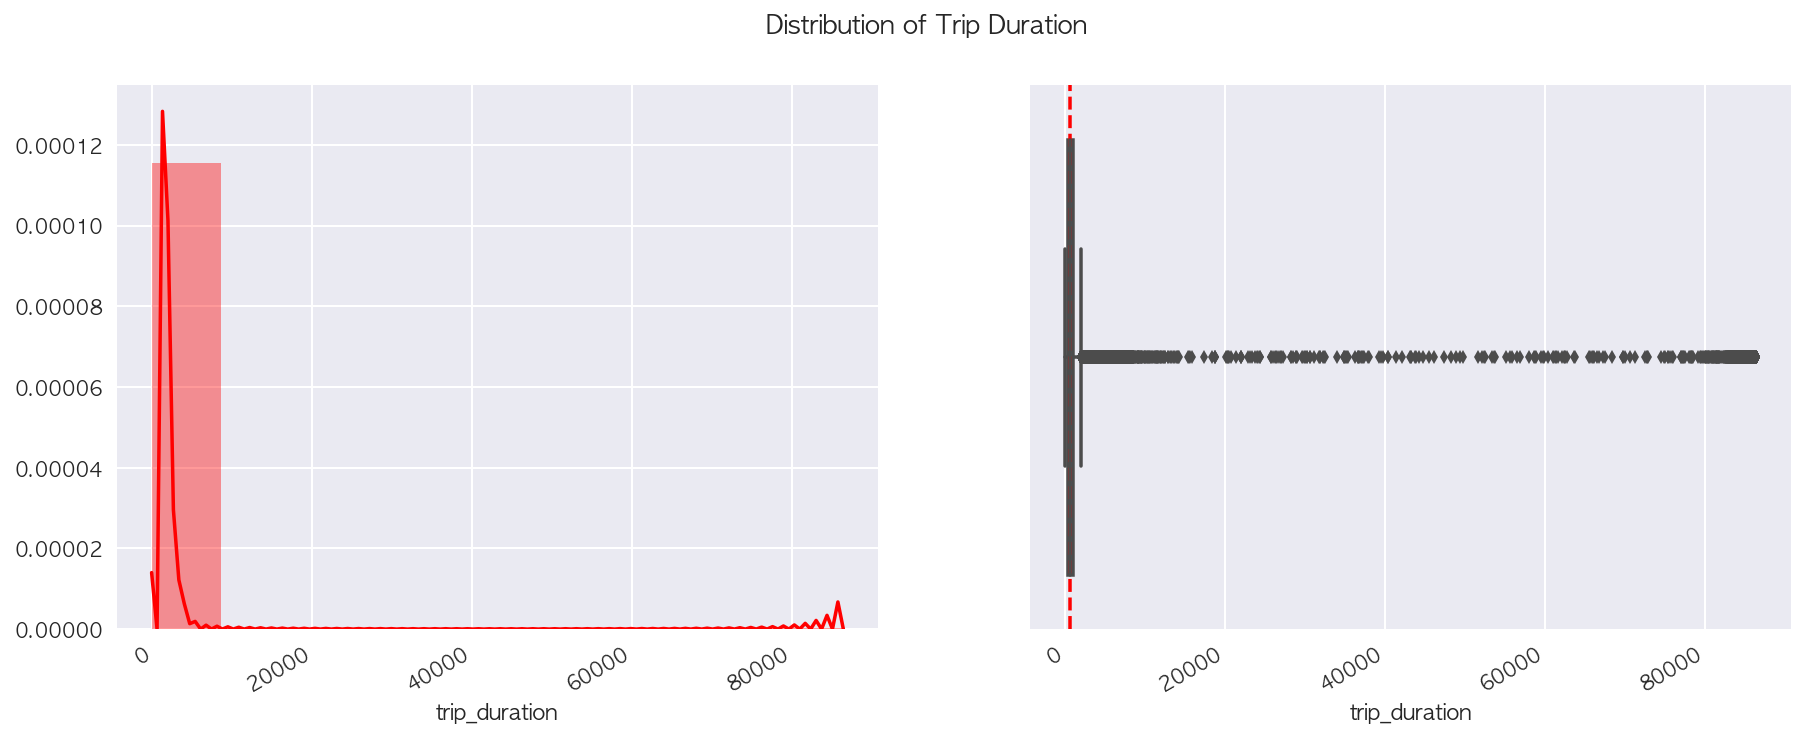

In [142]:
train = train[train["trip_duration"] < 1500000]

plt.figure(figsize=(15, 5))
plt.suptitle("Distribution of Trip Duration", fontsize=13)

plt.subplot(121)
sns.distplot(train["trip_duration"], color="r",bins=10)
plt.xticks(rotation=30, ha='right')

plt.subplot(122)
sns.boxplot(train["trip_duration"])
plt.axvline(train["trip_duration"].median(), linestyle='dashed', color="r")
plt.xticks(rotation=30, ha='right')

plt.show()

### 종속변수/독립변수 분리 후 pairplot
- 실수 변수
- 카테고리 변수

In [143]:
X_cols = [col for col in train.columns if col != "trip_duration"]
train_X0 = train[X_cols]
train_y = train[["trip_duration"]]

In [144]:
col_real = ["passenger_count", "distance", "bearing", "pickup_longitude", 
            "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

col_cats = [col for col in train.columns if col not in col_real]
for col in ["pickup_datetime", "dropoff_datetime", "id"]:
    col_cats.remove(col)
col_cats_nontime = ["vendor_id", "store_and_fwd_flag", "working_day"]

### trip_duration ~ 실수 변수  pairplot
- trip_duration
- passenger_count
- distance
- bearing

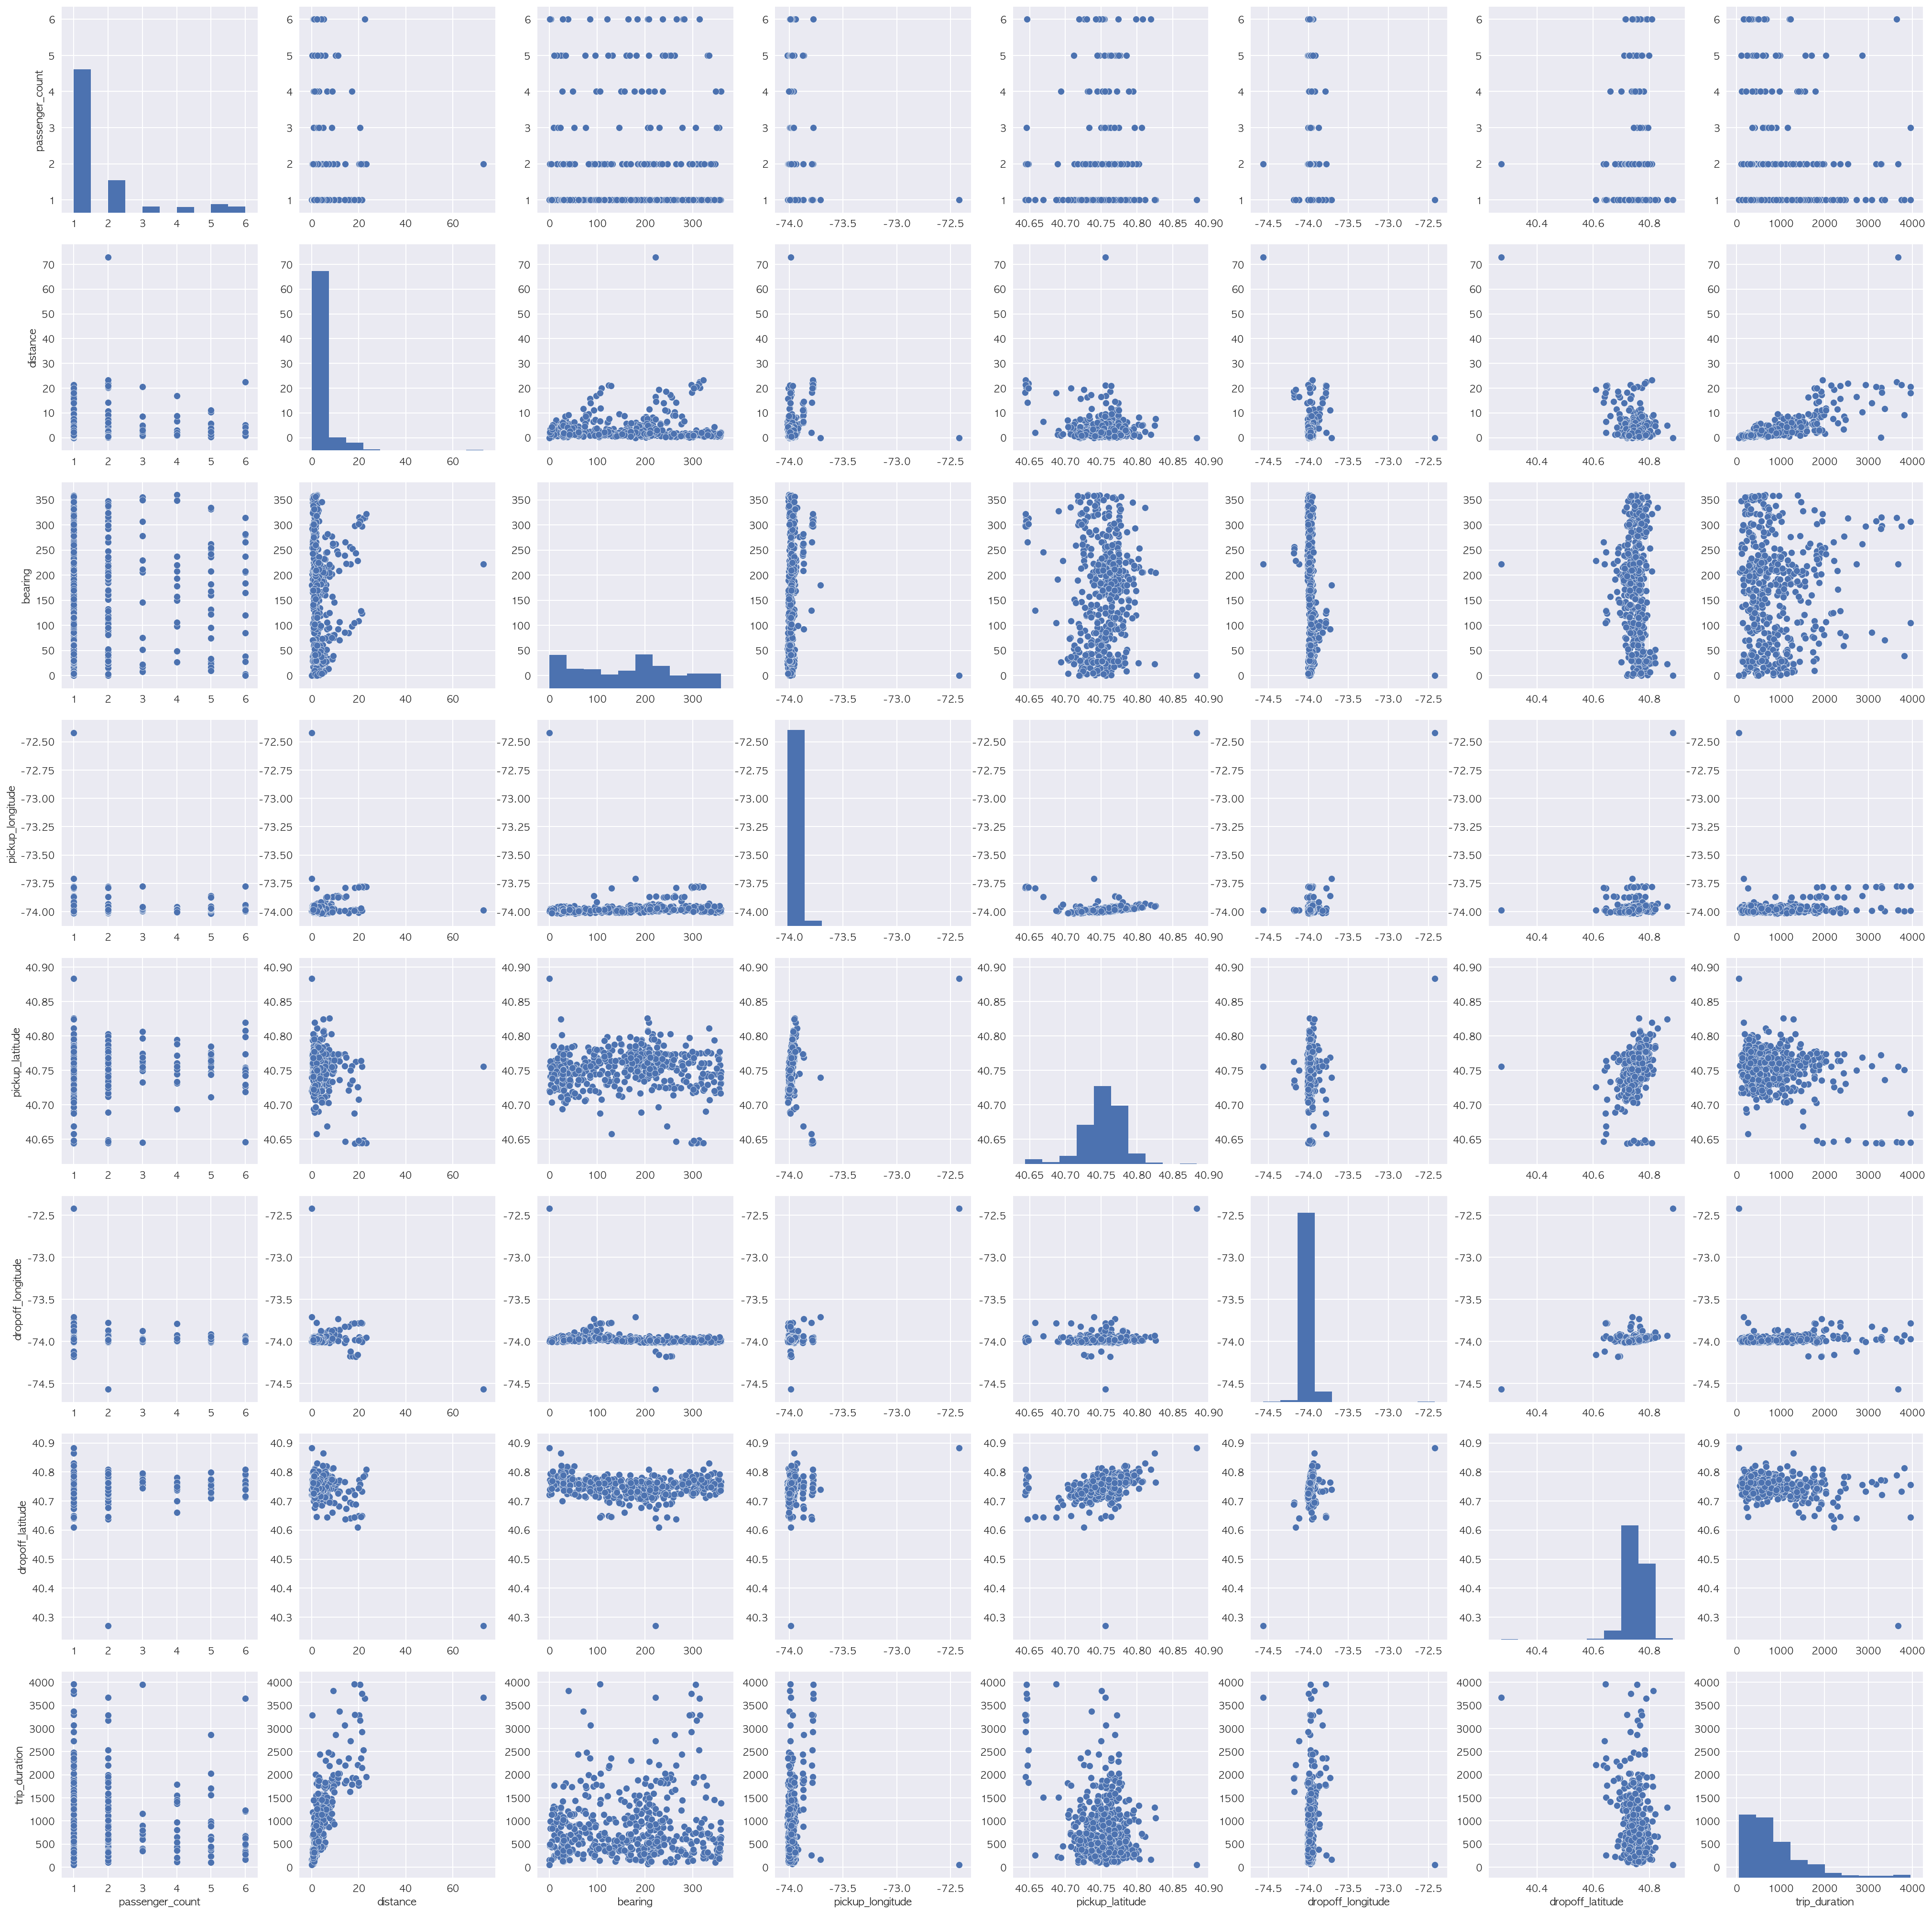

In [149]:
sns.pairplot(pd.concat([train_X0[col_real], train_y], axis=1)[::3000], size=3.5)
plt.show()

### 카테고리 변수 boxplot

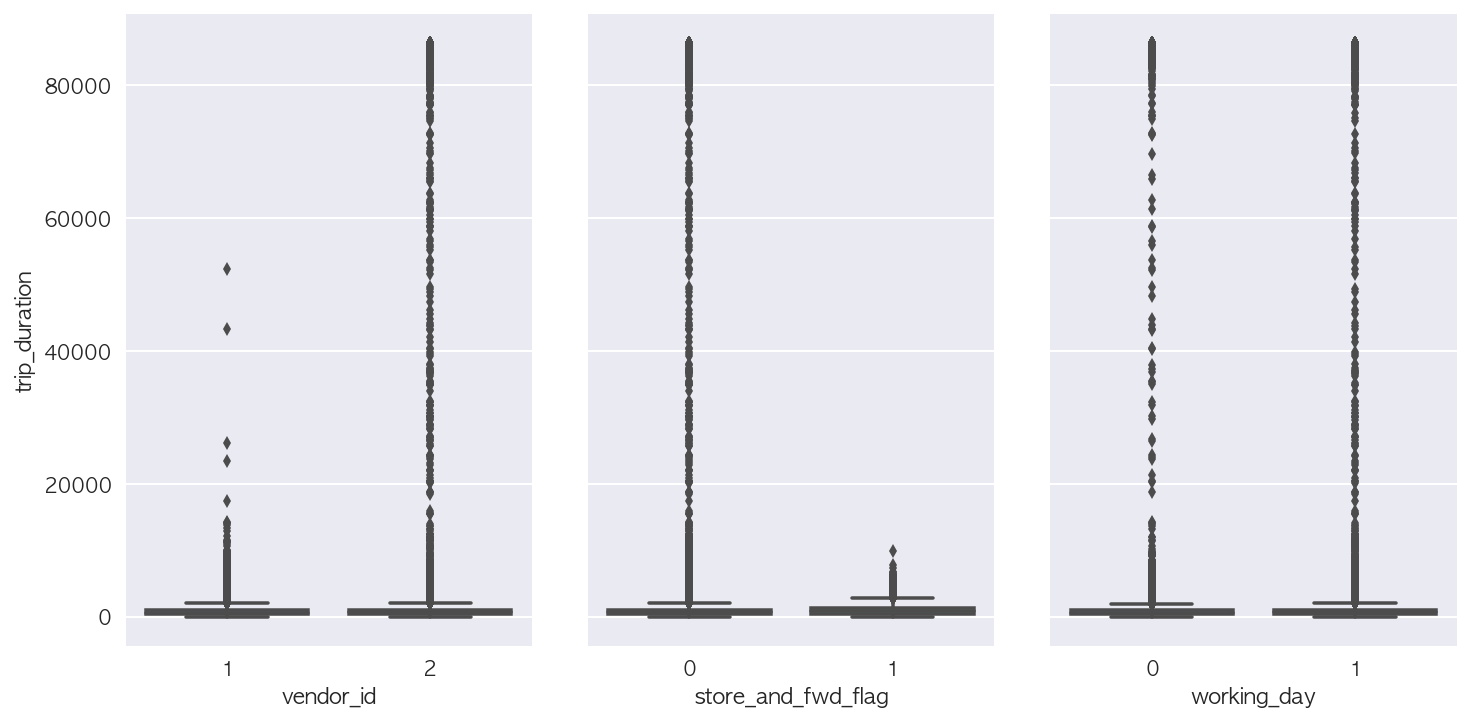

In [166]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)
f.tight_layout()

sns.boxplot(x="vendor_id", y="trip_duration", data=train, ax=axes[0])
sns.boxplot(x="store_and_fwd_flag", y="trip_duration", data=train, ax=axes[1])
sns.boxplot(x="working_day", y="trip_duration", data=train, ax=axes[2])

axes[1].set_ylabel('')
axes[2].set_ylabel('')

plt.show()

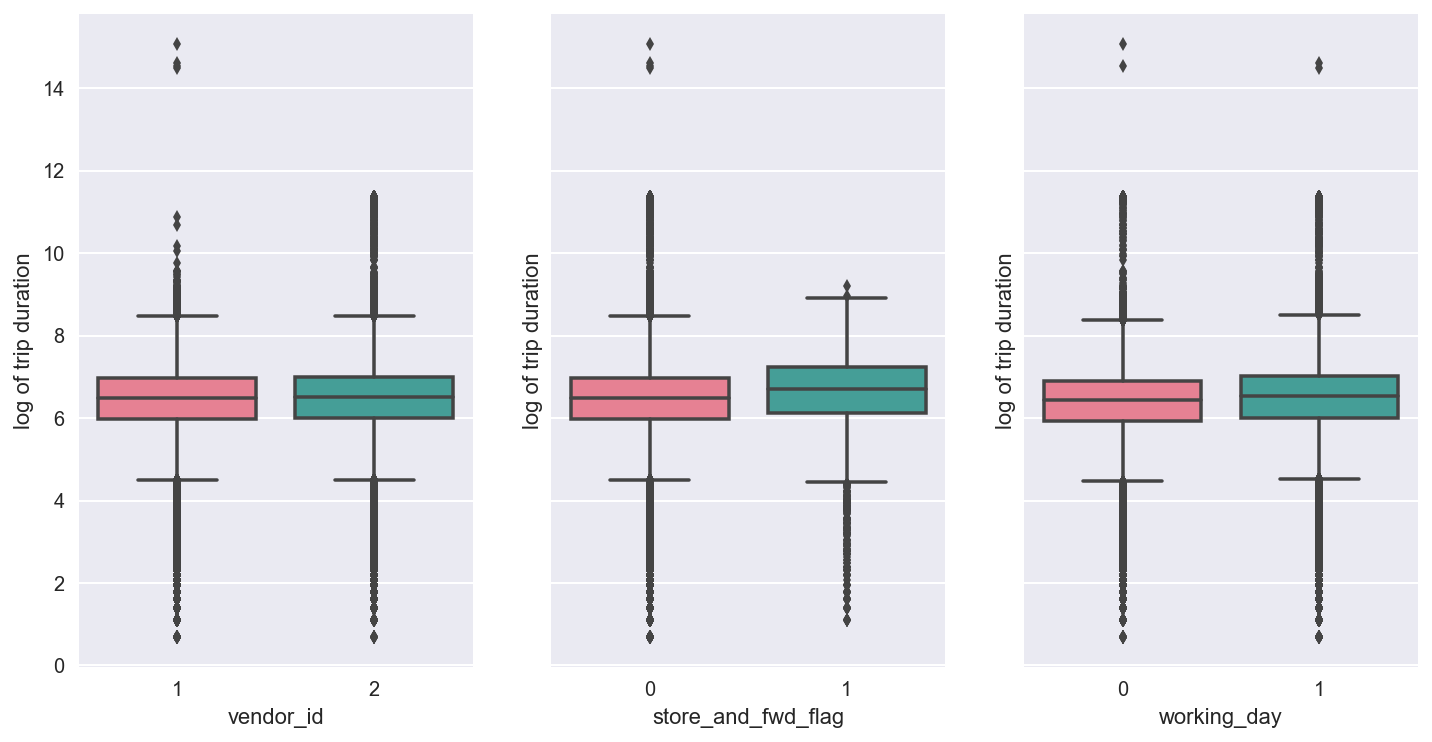

In [26]:
display_boxplots("vendor_id", 1, 3)

### 위치 변수의 분포

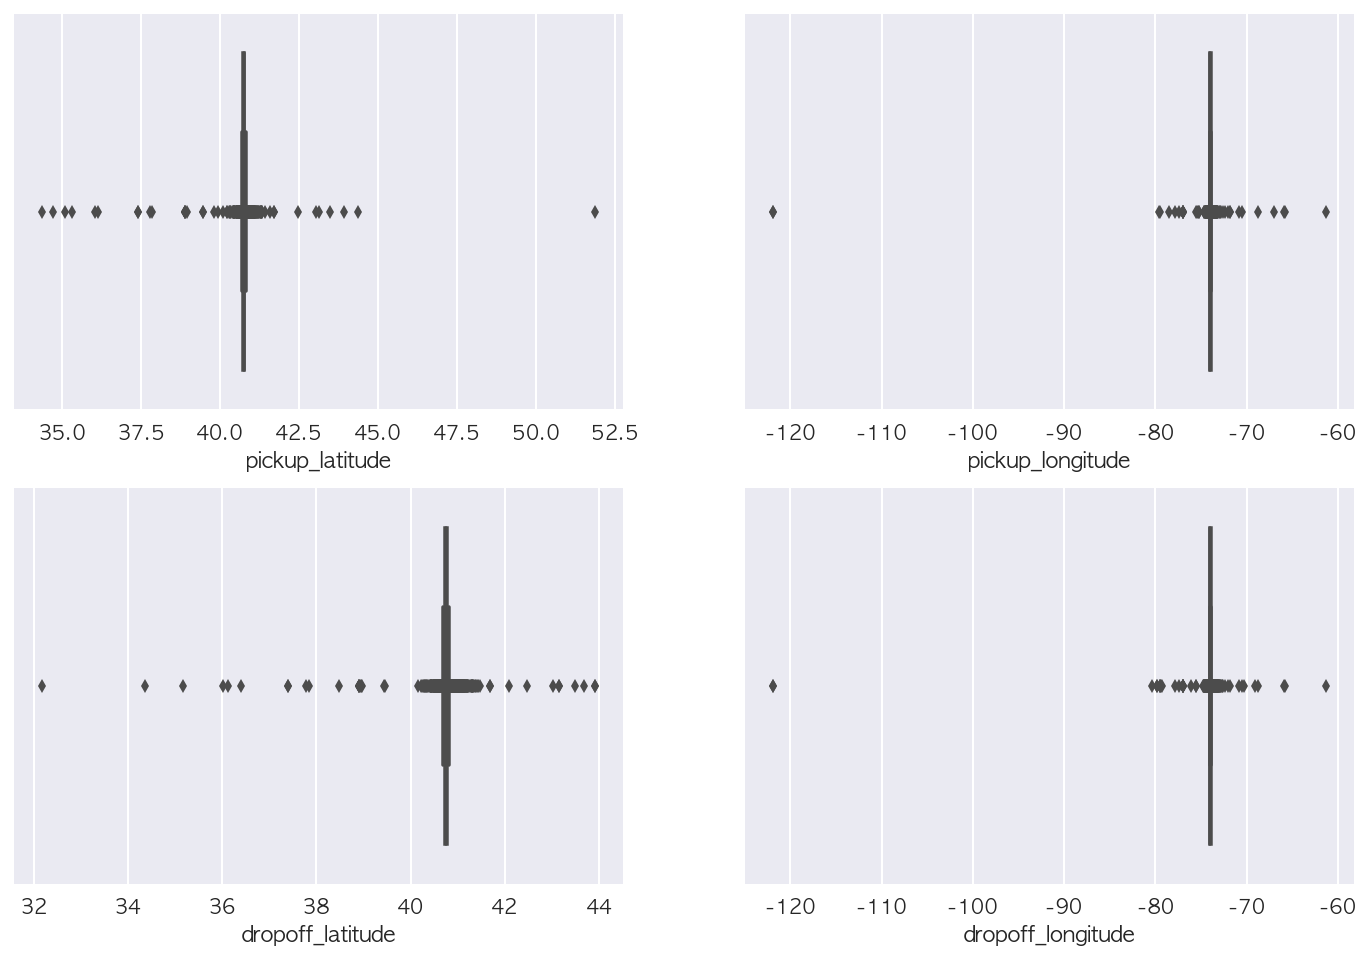

In [79]:
plt.figure(figsize=(12, 8))

plt.subplot(221); sns.boxplot(train["pickup_latitude"])
plt.subplot(222); sns.boxplot(train["pickup_longitude"])
plt.subplot(223); sns.boxplot(train["dropoff_latitude"])
plt.subplot(224); sns.boxplot(train["dropoff_longitude"])

plt.show()

- **NYC 경계:**
    - latitude: 약 40.5 ~ 40.90
    - longitude: 약 -74.24 ~ -73.70

In [120]:
weird_p = train.loc[(train["pickup_latitude"]>45) | (train["pickup_longitude"]<-100)]
weird_d = train.loc[(train["dropoff_latitude"]<36) | (train["dropoff_longitude"]<-120)]

import folium
map_weird = folium.Map(location=[38.720716, -100.721951], tiles='OpenStreetMap', zoom_start=3)

for idx, row in weird_p.iterrows(): 
    folium.CircleMarker([row["pickup_latitude"], row["pickup_longitude"]], 
                        radius=3, color="red", fill=True, fill_color="red").add_to(map_weird)

for idx, row in weird_d.iterrows(): 
    folium.CircleMarker([row["dropoff_latitude"], row["dropoff_longitude"]], 
                        radius=3, color="blue", fill=True, fill_color="blue").add_to(map_weird)
map_weird

<img src=https://github.com/novdov/dss7b5-nyctaxi/blob/master/img/nyc_map_plot.png?raw=true, style="width: 800px;"/>

In [171]:
# folium 코드

# map_nyc = folium.Map(location=[40.767937, -73.982155], tiles='OpenStreetMap', zoom_start=11)
# for idx, row in train[::7000].iterrows():
#     if pd.notnull(row["pickup_latitude"]):
#         folium.CircleMarker([row["pickup_latitude"], row["pickup_longitude"]], 
#                             radius=3, color="red", fill=True, fill_color="red").add_to(map_nyc)        
#         folium.CircleMarker([row["dropoff_latitude"], row["dropoff_longitude"]], 
#                             radius=3, color="blue", fill=True, fill_color="blue").add_to(map_nyc)       
# map_nyc

### 시간 변수 plot

### trip_duration ~ pickup_month 

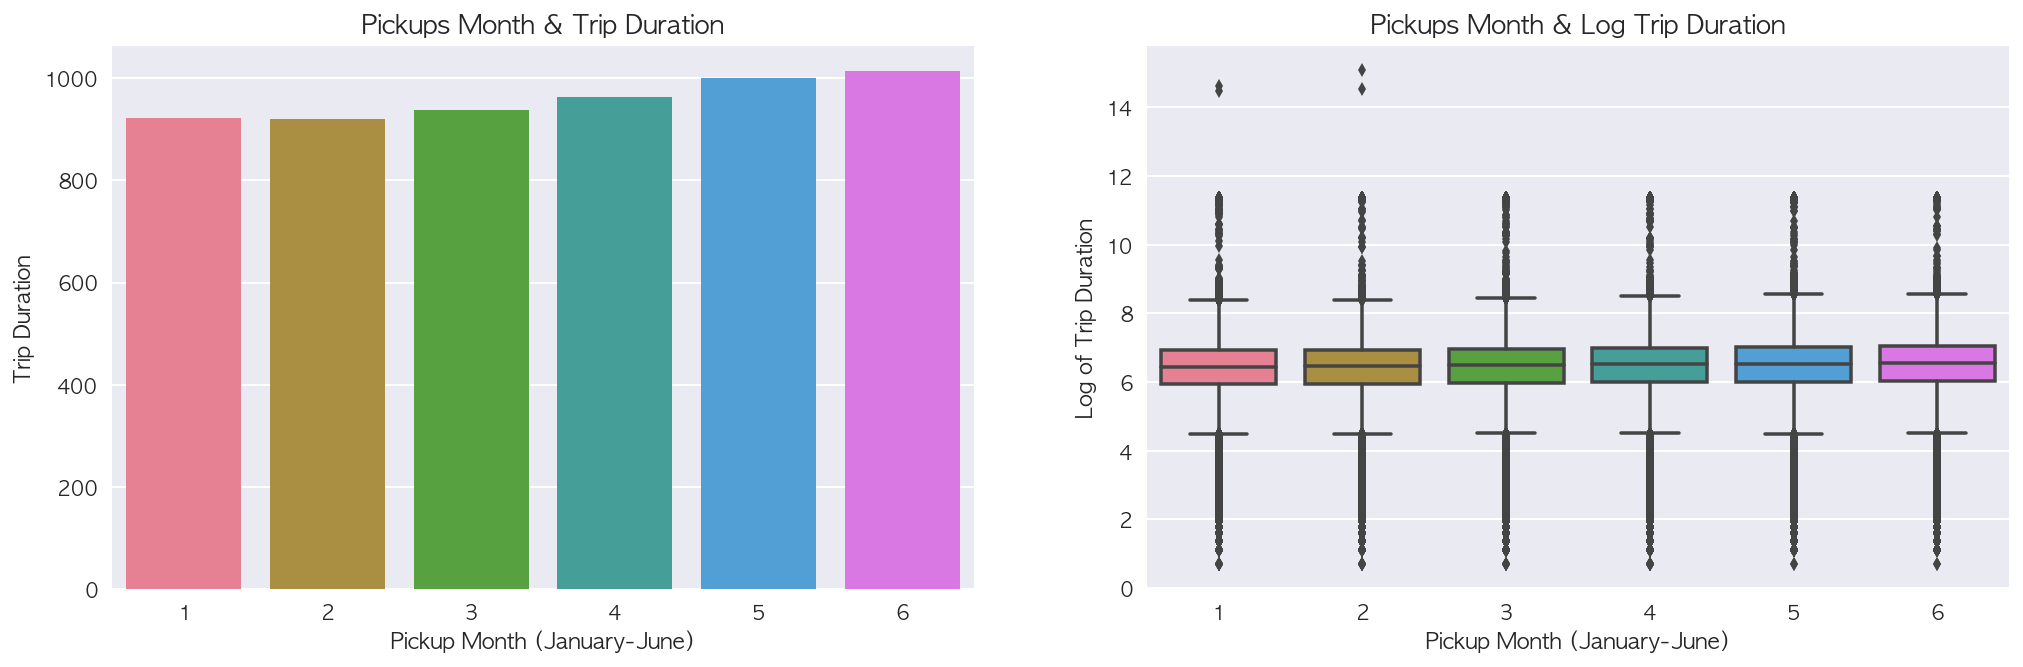

In [28]:
data = train.loc[:, ["pickup_month", "trip_duration"]].groupby("pickup_month").mean()

plt.figure(figsize=(17, 5))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Month & Trip Duration", fontsize=13)
plt.xlabel("Pickup Month (January-June)")
plt.ylabel("Trip Duration")

plt.subplot(122)
sns.boxplot(x=train["pickup_month"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Month & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Month (January-June)"); 
plt.ylabel("Log of Trip Duration")

plt.show()

### trip_duration ~ pickup_weekday

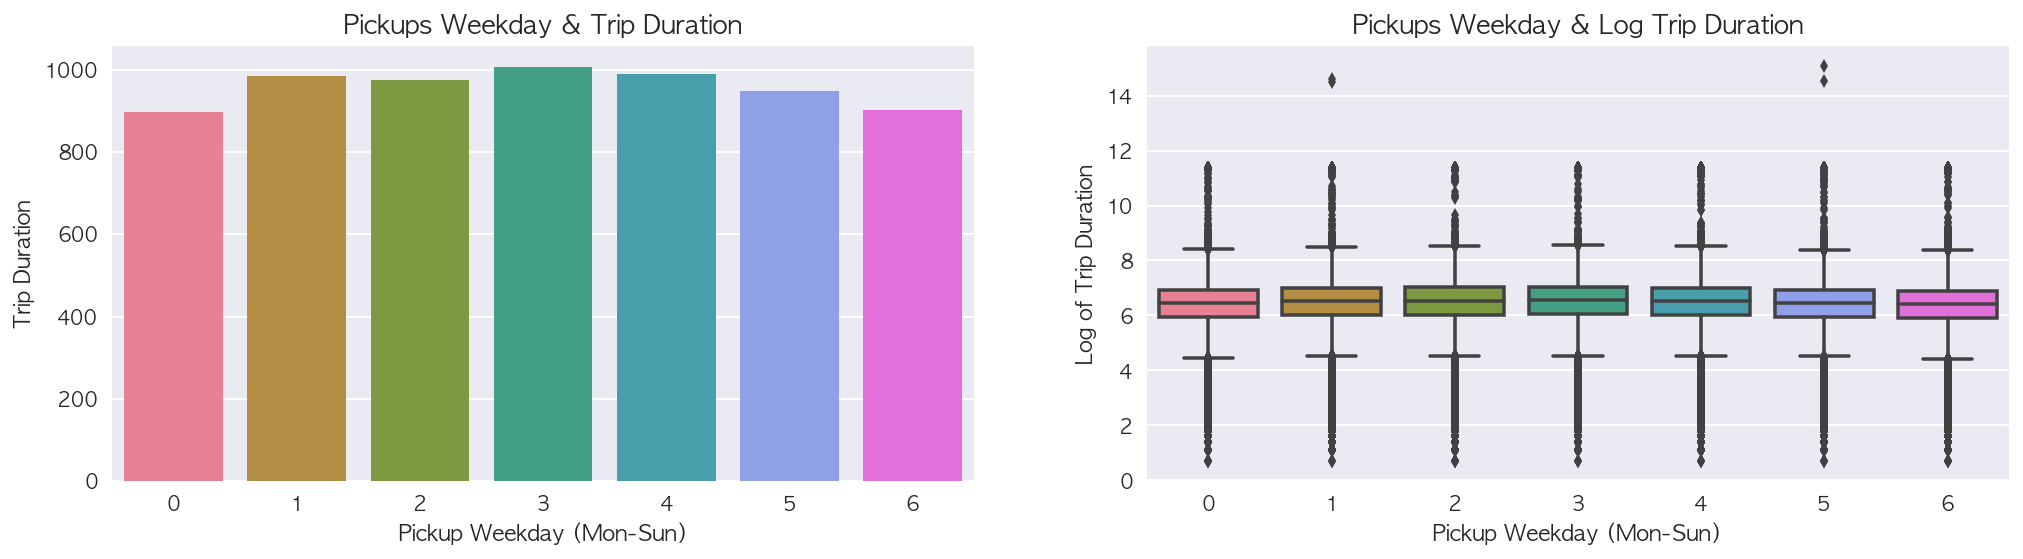

In [29]:
data = train.loc[:, ["pickup_weekday", "trip_duration"]].groupby("pickup_weekday").mean()

plt.figure(figsize=(17, 4))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Weekday & Trip Duration", fontsize=13)
plt.xlabel("Pickup Weekday (Mon-Sun)")
plt.ylabel("Trip Duration")

plt.subplot(122)
sns.boxplot(x=train["pickup_weekday"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Weekday & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Weekday (Mon-Sun)")
plt.ylabel("Log of Trip Duration")

plt.show()

### trip_duration ~ pickup_hour

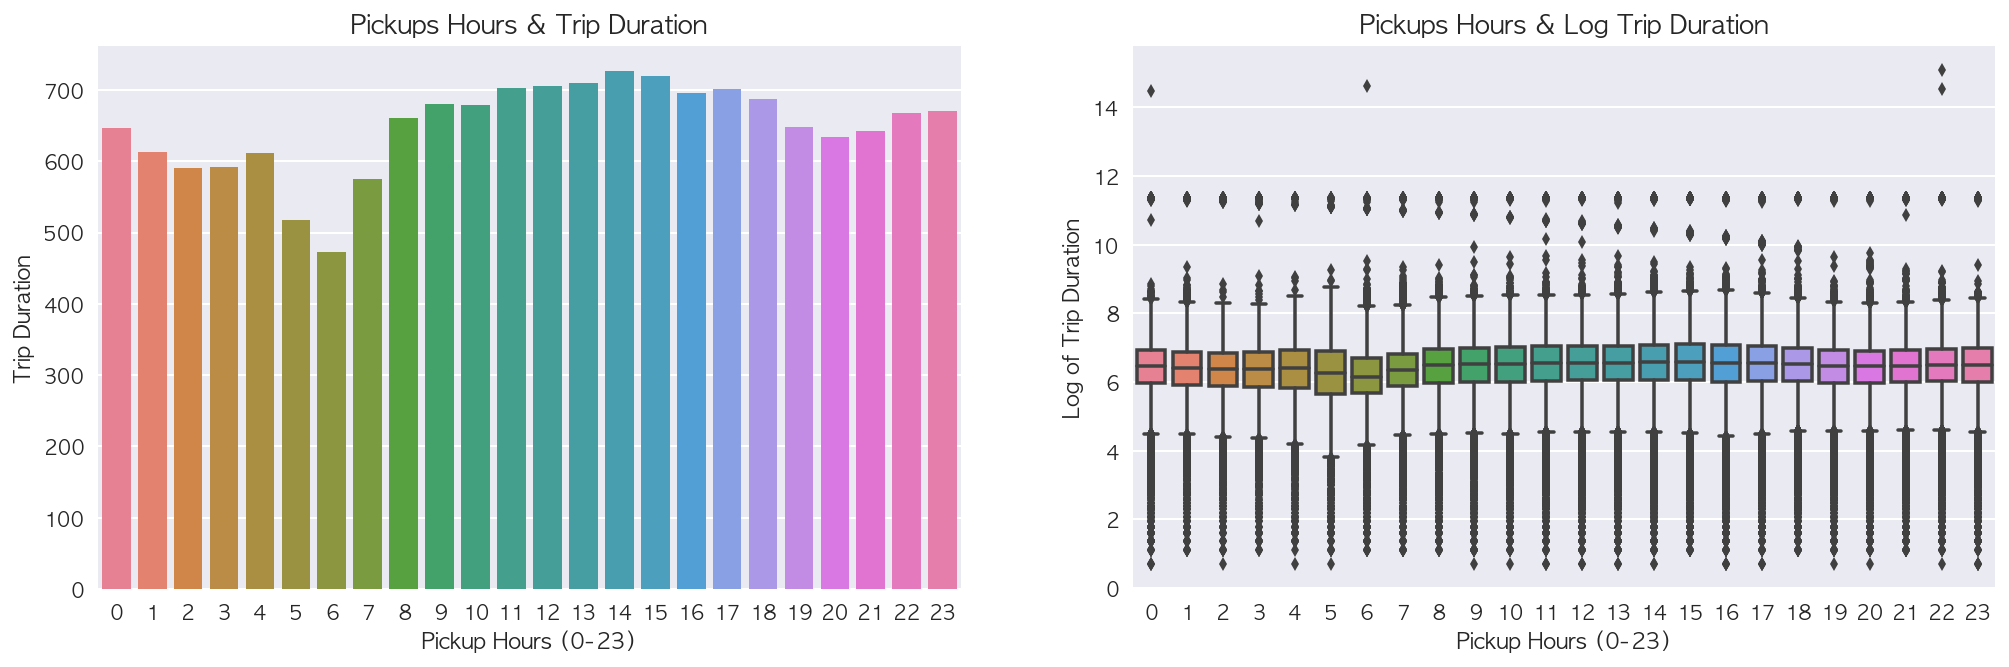

In [30]:
data = train.loc[:, ["pickup_hour", "trip_duration"]].groupby("pickup_hour").median()

plt.figure(figsize=(17, 5))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Hours & Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours (0-23)")
plt.ylabel("Trip Duration")


plt.subplot(122)
sns.boxplot(x=train["pickup_hour"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Hours & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours (0-23)")
plt.ylabel("Log of Trip Duration")

plt.show()

### working_day를 반영한 pickup_month

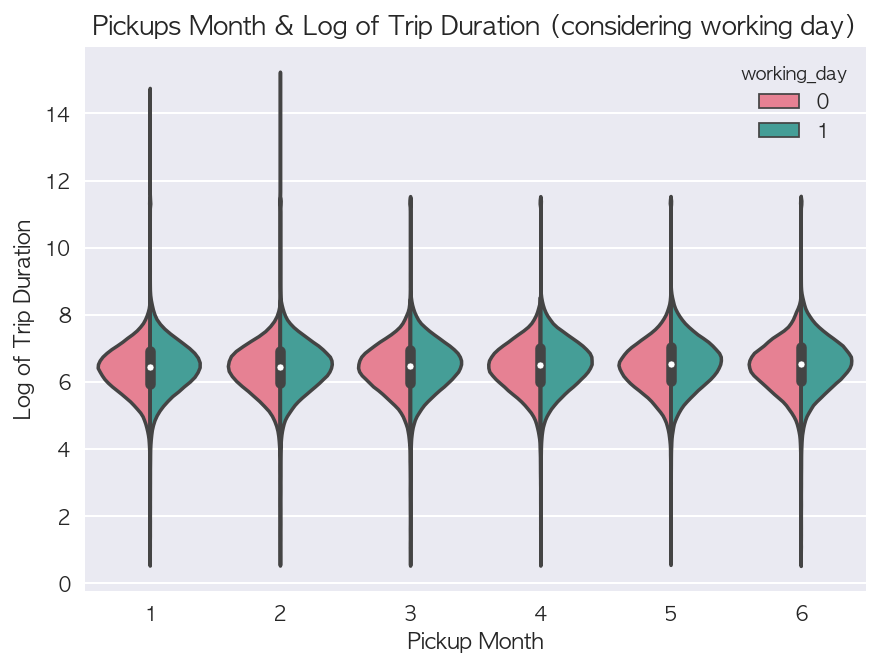

In [31]:
wd = train.loc[:, ["pickup_month", "pickup_hour", "trip_duration", "working_day"]]

plt.figure(figsize=(7, 5))
sns.violinplot(x=wd["pickup_month"], 
               y=wd["trip_duration"].apply(np.log1p),
               hue="working_day",
               data=wd, palette="husl", split=True)
plt.title("Pickups Month & Log of Trip Duration (considering working day)", fontsize=13)
plt.xlabel("Pickup Month")
plt.ylabel("Log of Trip Duration")
# plt.xticks(range(0, 6), month)
plt.show()

### working_day를 반영한 pickup_hour

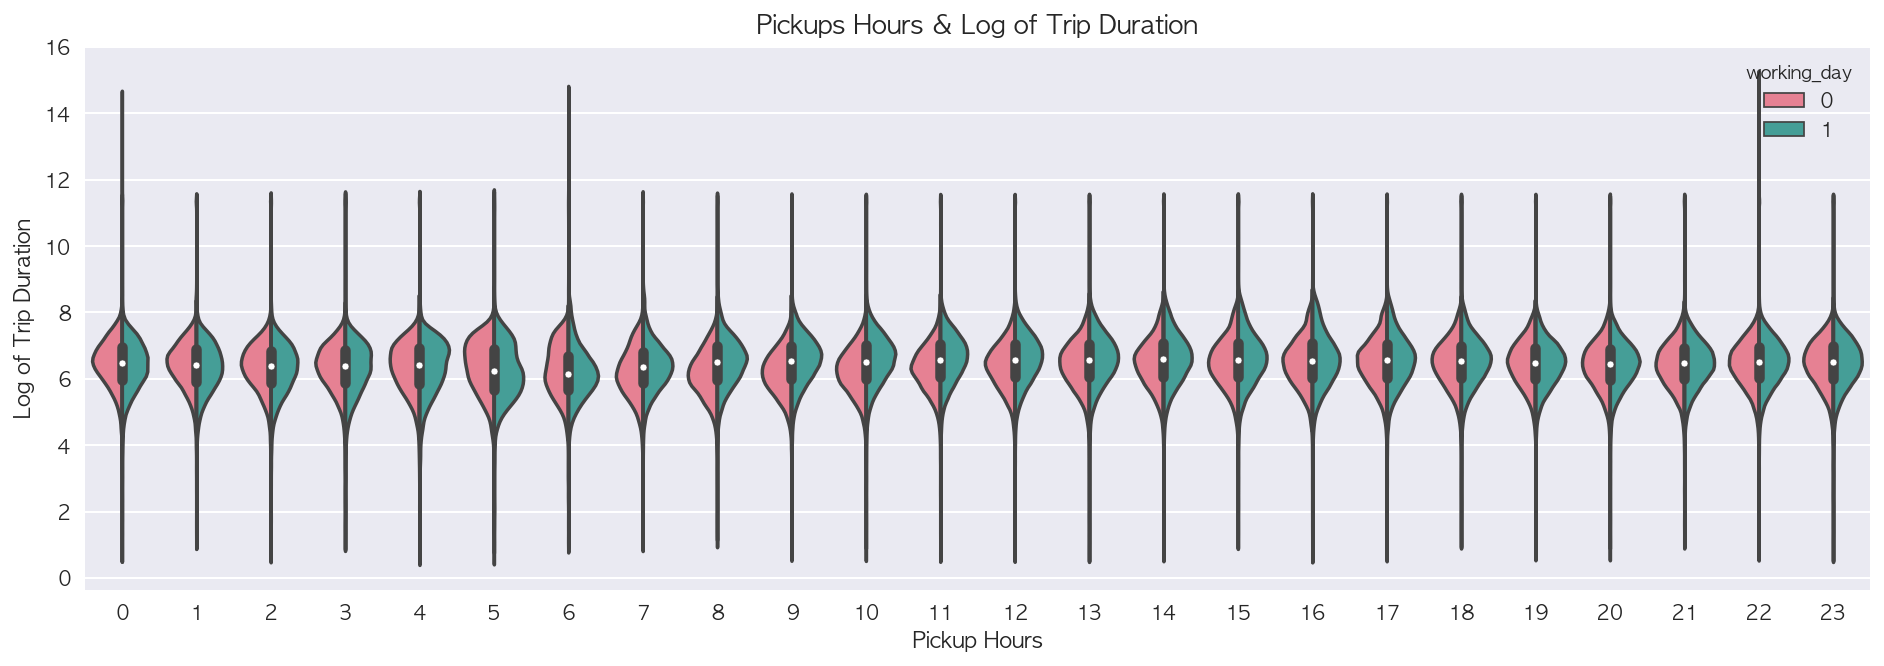

In [32]:
wd = train.loc[:, ["pickup_month", "pickup_hour", "trip_duration", "working_day"]]

plt.figure(figsize=(16, 5))
sns.violinplot(x=wd["pickup_hour"], 
               y=wd["trip_duration"].apply(np.log1p),
               hue="working_day",
               data=wd, palette="husl", split=True)
plt.title("Pickups Hours & Log of Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours")
plt.ylabel("Log of Trip Duration")
# plt.xticks(range(0, 6), month)
plt.show()

### 2-2. 변수간 상관관계 heatmap

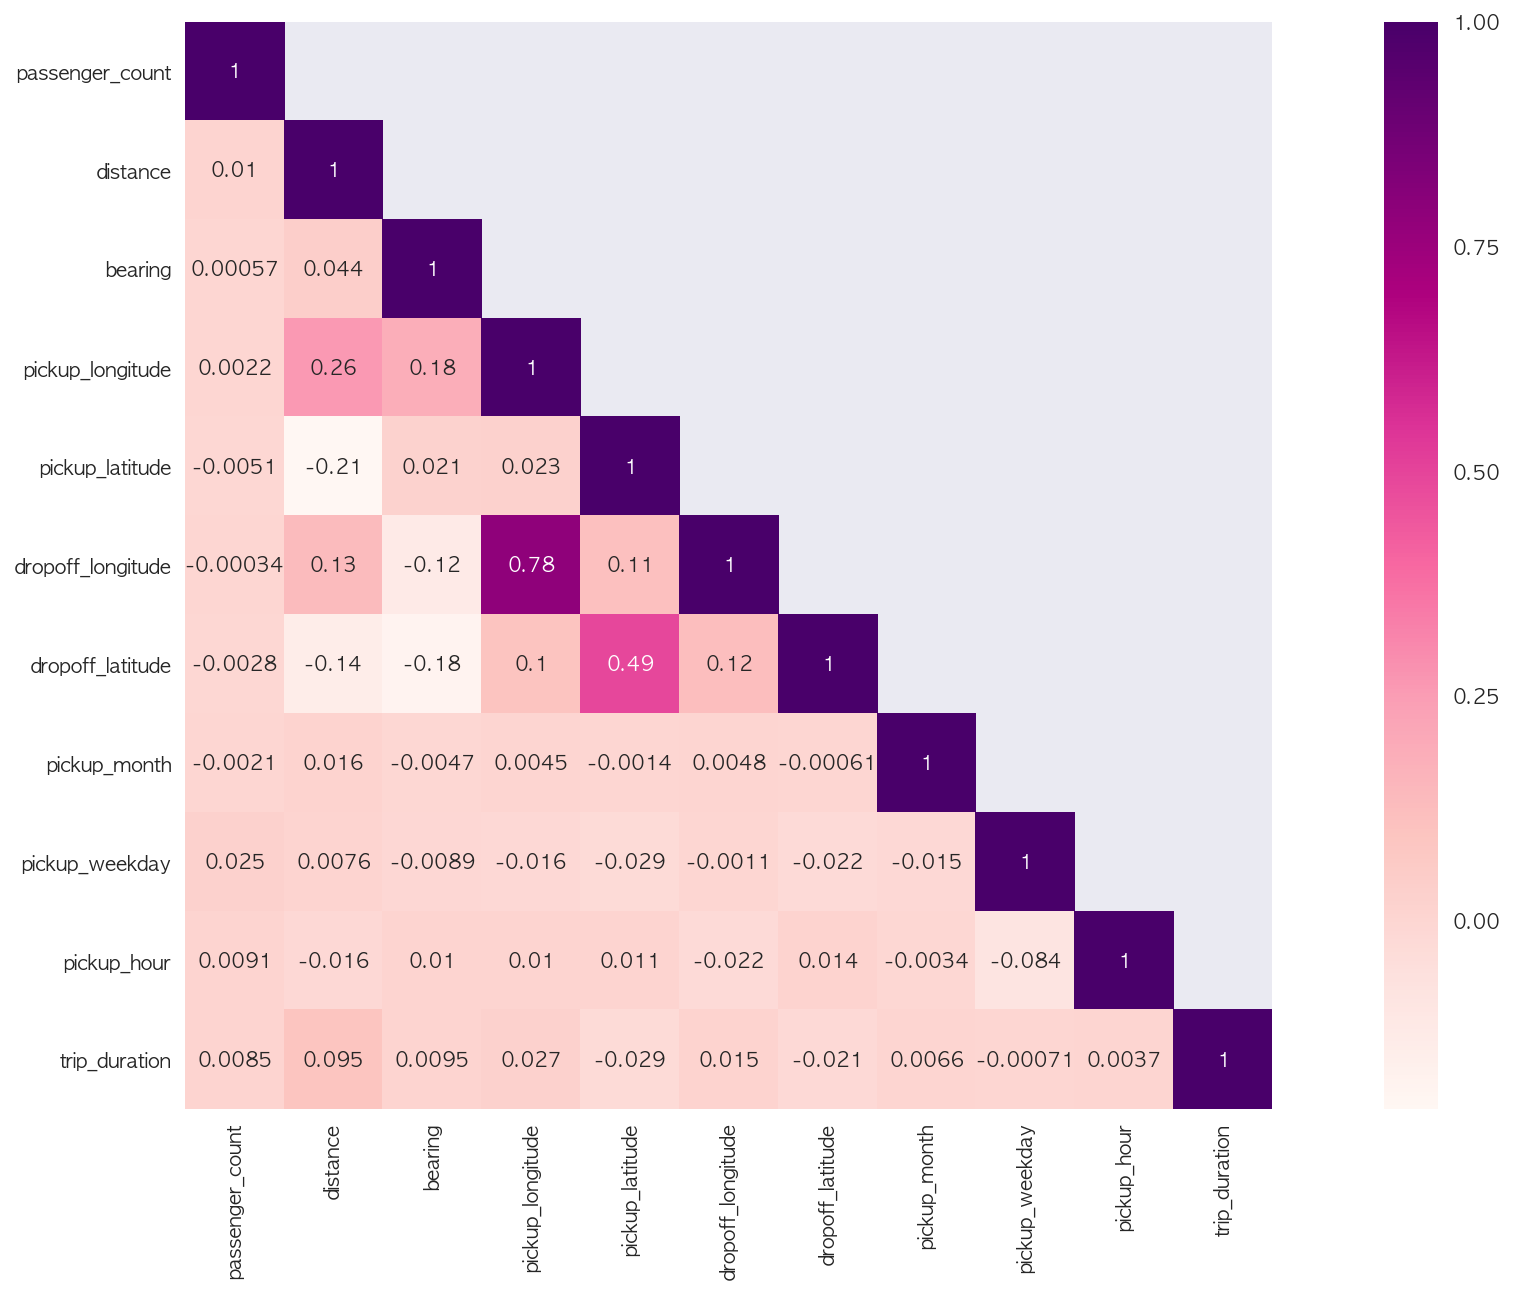

In [33]:
col_reals = col_real + ["pickup_month", "pickup_weekday", "pickup_hour", "trip_duration"]

corr_matt = train[col_reals].corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr_matt, mask=mask, annot=True, square=True, cmap="RdPu")
plt.show()

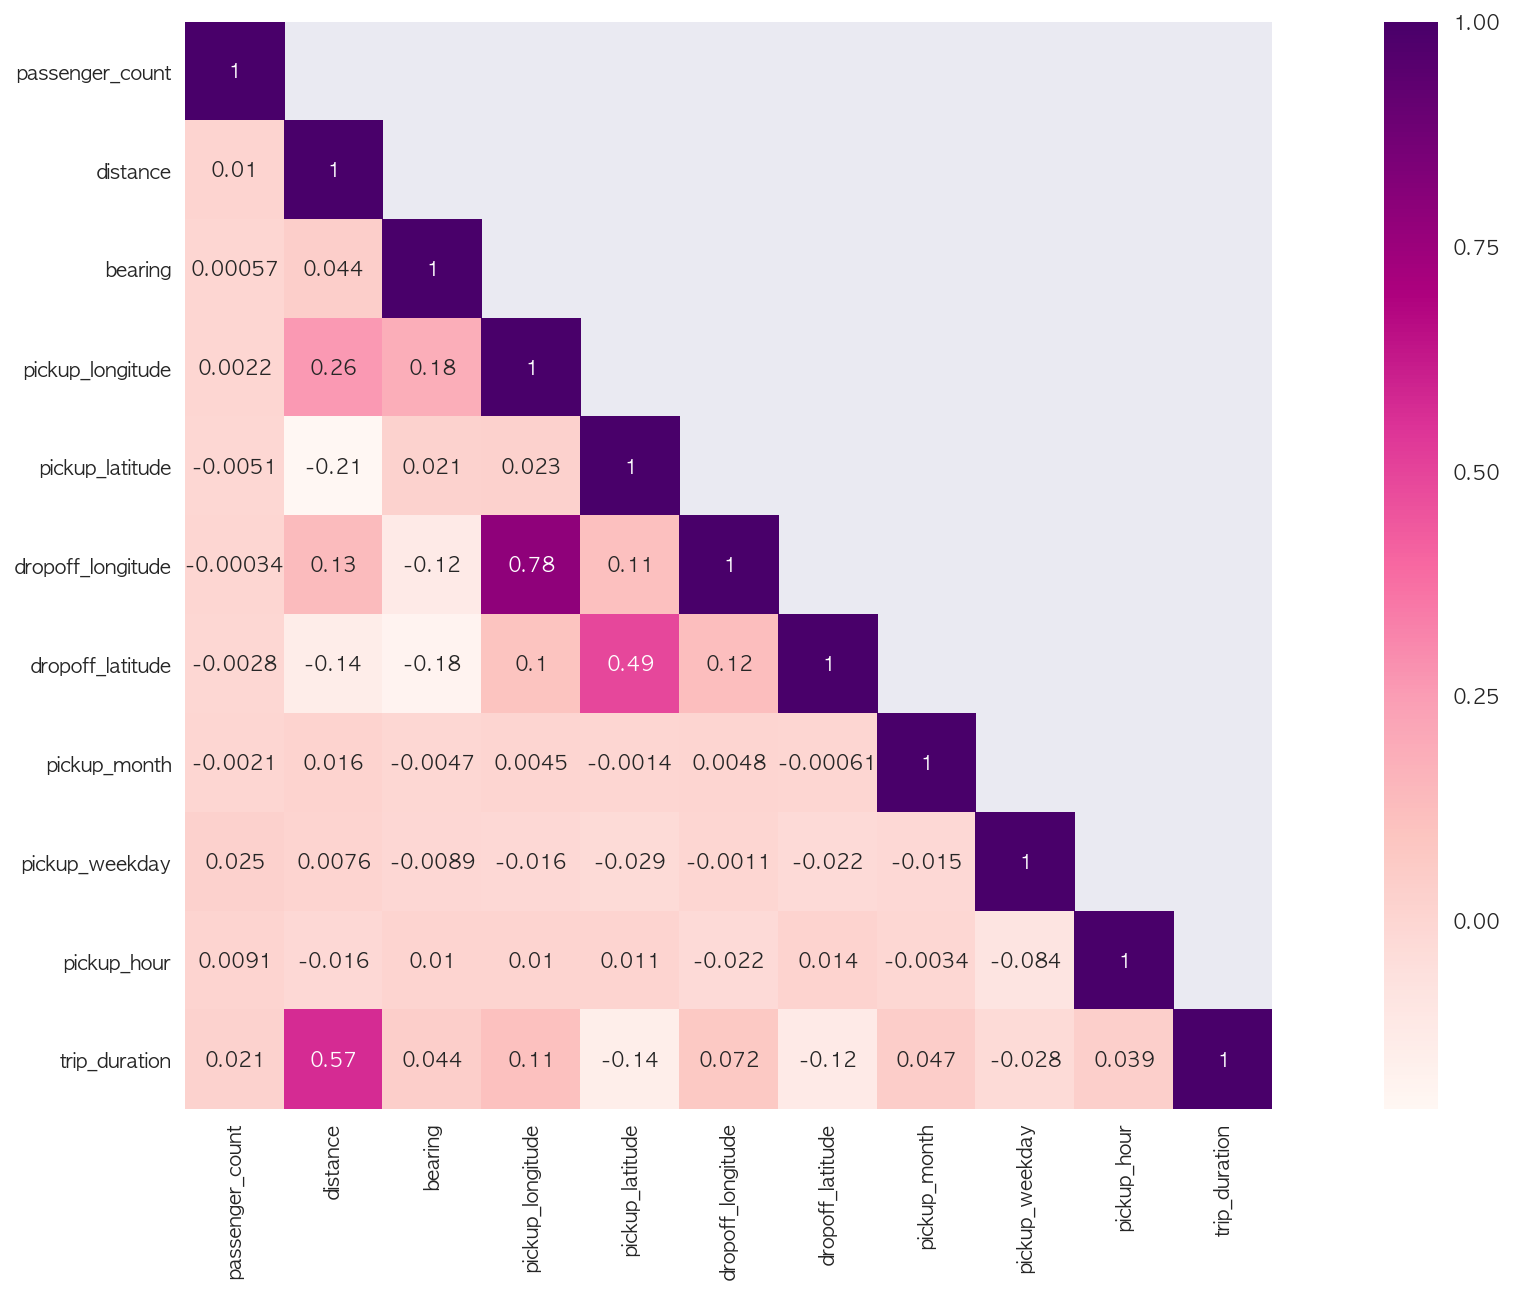

In [34]:
train_log = train[col_reals].copy()
train_log["trip_duration"] = np.log1p(train_log["trip_duration"])

corr_matt_log = train_log.corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr_matt_log, mask=mask, annot=True, square=True, cmap="RdPu")
plt.show()

### 2-2. 변수 중요도 파악 (F-검정)

### 전체 변수 F-검정

In [35]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude +"
                            "dropoff_latitude + dropoff_longitude + vendor_id + store_and_fwd_flag"
                            "+ working_day", train)
result = model.fit()

In [36]:
print("R-squared of a model:", result.rsquared)
print("Adjusted R-squared of a model:", result.rsquared_adj)

R-squared of a model: 0.0096206615429
Adjusted R-squared of a model: 0.00961183481413


#### [결과]
- $R^2$와 $Adj. R^2$ 모두 매우 낮음
- 모든 변수들의 p-value가 0에 가까움

In [37]:
sm.stats.anova_lm(result, typ=2)

,sum_sq,df,F,PR(>F)
passenger_count,1.626971e+08,1.0,5.988770,1.439736e-02
distance,2.955514e+11,1.0,10879.047719,0.000000e+00
bearing,1.599128e+09,1.0,58.862798,1.691624e-14
pickup_month,1.129914e+09,1.0,41.591364,1.125240e-10
pickup_weekday,6.883444e+08,1.0,25.337491,4.813203e-07
pickup_hour,9.624404e+08,1.0,35.426777,2.648812e-09
pickup_latitude,2.846822e+09,1.0,104.789572,1.360810e-24
pickup_longitude,3.793841e+08,1.0,13.964872,1.862654e-04
dropoff_latitude,1.093949e+08,1.0,4.026753,4.478424e-02
dropoff_longitude,1.018331e+09,1.0,37.484085,9.218532e-10


### VIF 확인

In [90]:
col_reals = col_real + ["pickup_hour", "pickup_weekday", "pickup_month"]
train_reals = train[col_reals]

In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_reals.values, i) for i in range(train_reals.shape[1])]
vif["features"] = train_reals.columns
vif

,VIF Factor,features
0,2.606391e+00,passenger_count
1,1.714442e+00,distance
2,4.411248e+00,bearing
3,3.819268e+06,pickup_longitude
4,1.815531e+06,pickup_latitude
5,3.590561e+06,dropoff_longitude
6,1.596748e+06,dropoff_latitude
7,5.578616e+00,pickup_hour
8,3.468770e+00,pickup_weekday
9,5.379472e+00,pickup_month


- **위치 데이터의 VIF가 높게 나옴**

### 카테고리 변수 영향도 파악(t-검정, F-검정)

### t-검정

In [38]:
def ttest_ind_cats(var):
    tmp_list = train[var].unique()
    print(sp.stats.ttest_ind(train["trip_duration"][train[var] == tmp_list[0]], 
                             train["trip_duration"][train[var] == tmp_list[1]]))

In [39]:
bin_cats = ["vendor_id", "store_and_fwd_flag", "working_day"]

for _, elem in enumerate(bin_cats):
    print("[ {} ]".format(elem))
    ttest_ind_cats(elem)
    print("-" * 80)    

[ vendor_id ]
Ttest_indResult(statistic=24.527274857356531, pvalue=8.046167819039434e-133)
--------------------------------------------------------------------------------
[ store_and_fwd_flag ]
Ttest_indResult(statistic=-2.0825876188794363, pvalue=0.037289002528894187)
--------------------------------------------------------------------------------
[ working_day ]
Ttest_indResult(statistic=4.8414640555035238, pvalue=1.288991482784057e-06)
--------------------------------------------------------------------------------


### One-Way ANOVA
- vendor_id
- store_and_fwd_flag
- working_day

In [47]:
model_vd = sm.OLS.from_formula("trip_duration ~ C(vendor_id) + 0", data=train)
sm.stats.anova_lm(model_vd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(vendor_id),2.0,1.359360e+12,6.796800e+11,24788.28575,0.0
Residual,1458642.0,3.999509e+13,2.741940e+07,NaN,NaN


In [48]:
model_wd = sm.OLS.from_formula("trip_duration ~ C(working_day) + 0", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(working_day),2.0,1.343508e+12,6.717539e+11,24489.510168,0.0
Residual,1458642.0,4.001094e+13,2.743027e+07,NaN,NaN


In [49]:
model_flag = sm.OLS.from_formula("trip_duration ~ C(store_and_fwd_flag) + 0", data=train)
sm.stats.anova_lm(model_flag.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(store_and_fwd_flag),2.0,1.342984e+12,6.714919e+11,24479.638307,0.0
Residual,1458642.0,4.001147e+13,2.743063e+07,NaN,NaN


In [42]:
sp.stats.f_oneway(train[train["working_day"]==0]["trip_duration"], 
                  train[train["working_day"]==1]["trip_duration"])

F_onewayResult(statistic=23.439774200732664, pvalue=1.288991484260018e-06)

In [43]:
sp.stats.f_oneway(train[train["store_and_fwd_flag"]==0]["trip_duration"], 
                  train[train["store_and_fwd_flag"]==1]["trip_duration"])

F_onewayResult(statistic=4.337171190309931, pvalue=0.037289002569931756)

In [44]:
sp.stats.f_oneway(train[train["vendor_id"]==1]["trip_duration"], 
                  train[train["vendor_id"]==2]["trip_duration"])

F_onewayResult(statistic=601.58721192831376, pvalue=8.0461678290238255e-133)

## 3. OLS 회귀분석